# The goal here is to select 500 sites for SNOWPACK train simulations. First we will bin SMB into 100 quantiles, then select 5 from each. SMB will be determined by Brooke's model

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import xarray as xr
import glob, os, re
from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg

# Get smet/lat lon

In [2]:
tgt_dir = "/pl/active/icesheetsclimate/IDS_Antarctica/smet/*"
file_list = glob.glob(tgt_dir)
file_list_new = []

for j in range(0, len(file_list)):
    file_list[j] = os.path.basename(file_list[j])
    if not (file_list[j].startswith("D") or file_list[j].startswith("T")):
        file_list_new.append(file_list[j])

lat = np.zeros(len(file_list_new)); lat[:] = np.nan
lon = np.zeros(len(file_list_new)); lon[:] = np.nan        
for j in range(0, len(file_list_new)):
    tmp_list = re.split('_|.smet', file_list_new[j])
    lat[j] = tmp_list[0]
    lon[j] = tmp_list[1]

# Get the SMB for each lat/lon pair

In [3]:
def lat_lon_to_epsg3031(tgt_lat, tgt_lon):
    # Source and target EPSG
    src = osr.SpatialReference()
    tgt = osr.SpatialReference()
    src.ImportFromEPSG(4326) # WGS-84
    tgt.ImportFromEPSG(3031) # South Polar Stereo
    
    # Define transformation
    transform = osr.CoordinateTransformation(src, tgt)
    
    # Initialize arrays
    tgt_x = np.zeros(len(tgt_lat)); tgt_x[:] = np.nan
    tgt_y = np.zeros(len(tgt_lat)); tgt_y[:] = np.nan
    
    # Perform transformation
    for j in range(0, len(tgt_x)):
        coords = transform.TransformPoint(float(tgt_lat[j]), float(tgt_lon[j]))
        tgt_x[j], tgt_y[j] = coords[0:2]
    
    return tgt_x, tgt_y

# Function to get ratio at lat/lon
def get_RF_M2_ratio(tgt_lat, tgt_lon):
    
    # Get M2 SMB at lat/lon
    M2_smb = xr.open_dataset("M2_annual-mean-SMB.nc")
    M2_smb = M2_smb['__xarray_dataarray_variable__']
    tgt_lat = xr.DataArray(tgt_lat, dims="points")
    tgt_lon = xr.DataArray(tgt_lon, dims="points")
    M2_smb = M2_smb.sel(lat=tgt_lat, lon=tgt_lon, method='nearest').values
        
    # Get RF at lat/lon
    tgt_x, tgt_y = lat_lon_to_epsg3031(tgt_lat, tgt_lon)
    tgt_x = xr.DataArray(tgt_x, dims="points")
    tgt_y = xr.DataArray(tgt_y, dims="points")
    M2_RF = xr.open_dataset("RF_Snow_Red_prelim.nc")
    M2_RF_sites = np.zeros(len(tgt_x)); M2_RF_sites[:] = np.nan
    for j in range(0, len(M2_RF_sites)):
        M2_RF_sites[j] = M2_RF['IS2_opt'].sel(x=tgt_x[j], y=tgt_y[j], method='nearest').values
    
    # Get ratio
    RF_ratio = (M2_RF_sites + M2_smb) / M2_smb
    RF_ratio = np.nan_to_num(RF_ratio, nan=1)
    M2_RF_sites = np.nan_to_num(M2_RF_sites, nan=0)
    
    return RF_ratio, M2_smb, M2_RF_sites

In [4]:
RF_ratio, M2_SMB, M2_RF = get_RF_M2_ratio(lat, lon)
SMB = M2_SMB + M2_RF

0.9769080130077222
0.17575204238486117


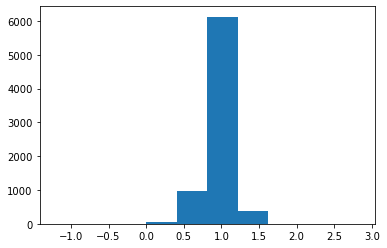

In [8]:
plt.hist(RF_ratio)
print(RF_ratio.mean())
print(RF_ratio.std())

# Sort SMB into quantiles, sample 4 lat/lon pairs from each quantile

In [5]:
# Get coastlines
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


7543


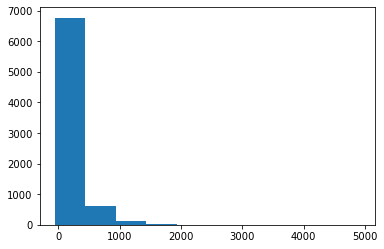

In [6]:
# All sites
plt.hist(SMB)
print(len(SMB))

400


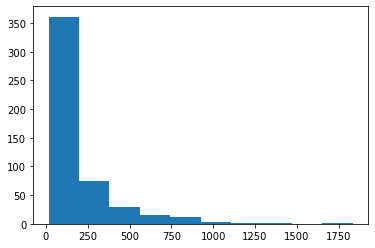

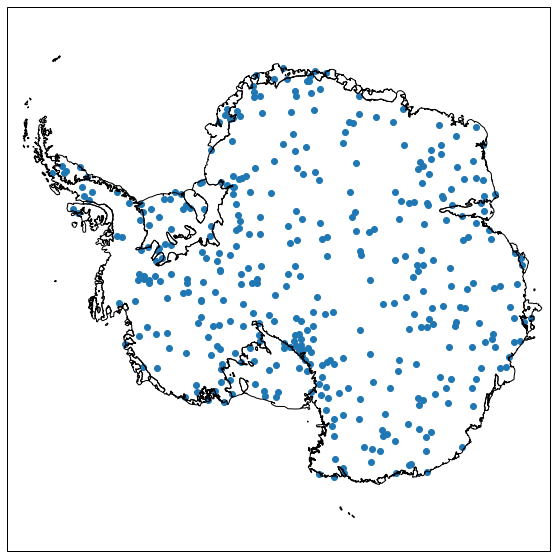

In [7]:
# 500 random 

# Histogram
indices = np.random.choice(np.arange(0, len(SMB)), 400, replace=False)
SMB_random = SMB[indices]
print(len(SMB_random))
plt.hist(np.random.choice(SMB, 500, replace=False))

# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot sites
plt.scatter(lon[indices], lat[indices], transform=ccrs.PlateCarree())

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

394


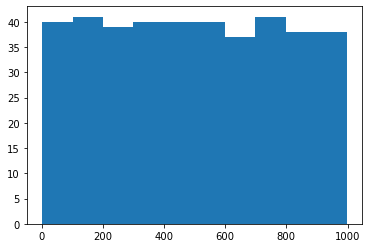

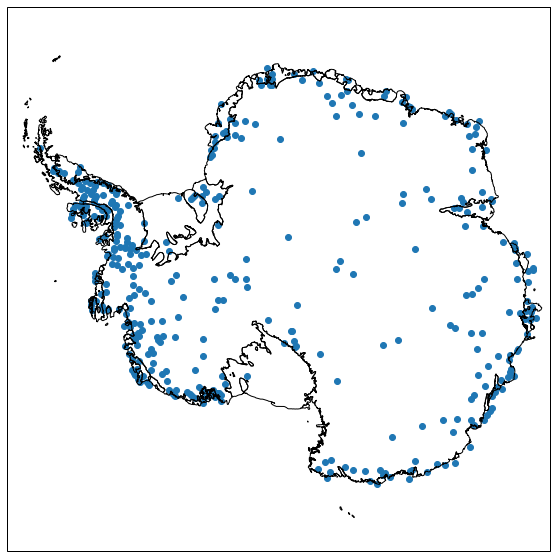

In [8]:
# Group by spacing
    
# Histogram
quantiles = np.linspace(0, 1000, 101)

ind_select = np.array([])
for j in range(0, len(quantiles) - 1):
    minima = quantiles[j]
    maxima = quantiles[j+1]
    indices = np.where(np.logical_and(SMB >= minima, SMB <= maxima))[0]
    
    if len(indices > 0):
        if len(indices) < 4:
            ind_tmp = np.random.choice(indices, len(indices), replace=False)
        else:
            ind_tmp = np.random.choice(indices, 4, replace=False)
        ind_select = np.append(ind_select, ind_tmp)

ind_select = ind_select.astype(int)
SMB_select = SMB[ind_select]
print(len(SMB_select))
plt.hist(SMB_select)

# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot sites
plt.scatter(lon[ind_select], lat[ind_select], transform=ccrs.PlateCarree())

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Write text file

In [9]:
files = np.array([])
for j in range(0, len(ind_select)):
    files = np.append(files, file_list_new[ind_select[j]])
files_unique = np.unique([files])
print(len(files))
print(len(files_unique))
np.savetxt("sites.txt", files_unique, fmt="%s")

394
394


In [12]:
# %%bash
# while read p; do
#   echo $p
# done <sites.txt